## Import libraries

In [ ]:
import scipy
import numpy
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
from IPython.core.pylabtools import figsize

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns

In [ ]:
# Set random seed for reproducibility
tf.random.set_seed(1234)

# Read and explore data 
While I import the data from a CSV file, I make sure the **Date** column has the correct *DateTime* format by **parse_dates = ['Date']**.

When I work with date and time, it becomes much easier if I set **Date** column as the dataframe index.

In [ ]:
file = 'https://raw.githubusercontent.com/shee35/ML-Dataset/main/osmanabad_Sp_Tp_data.csv'
raw_data = pd.read_csv(file, parse_dates = True)

df = raw_data.copy()

In [ ]:
# Explore the first five rows
df.head()

,sno,Dates,Current,Temporal,Spatial
0,1,4/26/2020,3,3.0,74.360000
1,2,4/27/2020,3,3.0,76.692308
2,3,4/28/2020,3,3.0,86.000000
3,4,4/29/2020,3,3.0,88.423077
4,5,4/30/2020,3,3.0,92.346154


In [ ]:
# Data description
df.describe()

,sno,Current,Temporal,Spatial
count,521.000000,521.000000,521.000000,521.000000
mean,261.000000,25969.850288,25713.121689,71046.073111
std,150.544013,23847.509009,23763.076476,62165.348930
min,1.000000,3.000000,3.000000,74.360000
25%,131.000000,6643.000000,6174.600000,18698.807690
50%,261.000000,17131.000000,17073.200000,47941.615380
75%,391.000000,54015.000000,51808.200000,146762.576900
max,521.000000,66915.000000,66849.000000,174842.730800


In [ ]:
# Find number of rows and columns
df = df.drop(columns='Dates')
df.shape

(521, 4)

**Plot Time-Series**


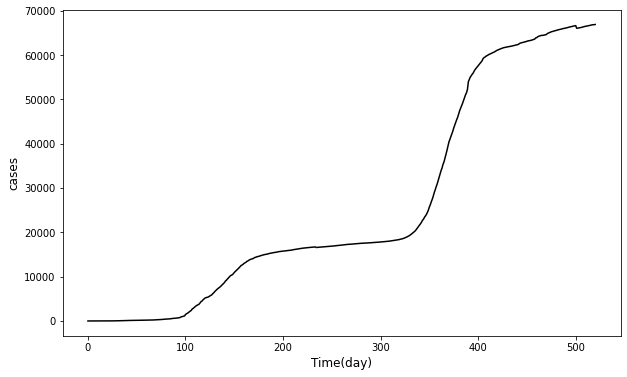

In [ ]:
# Define a function to draw time_series plot
def timeseries (x_axis, y_axis, x_label, y_label):
    plt.figure(figsize = (10, 6))
    plt.plot(x_axis, y_axis, color ='black')
    plt.xlabel(x_label, {'fontsize': 12})
    plt.ylabel(y_label, {'fontsize': 12})

timeseries(df.index, df['Current'],'Time(day)','cases')


## Split the dataset into train and test data
In this project, I set the first 80% of data as train data and the remaining 20% as test data. I train the model with train data and validate its performance with test data.

Dimension of train data:  (416, 4)
Dimension of test data:  (105, 4)


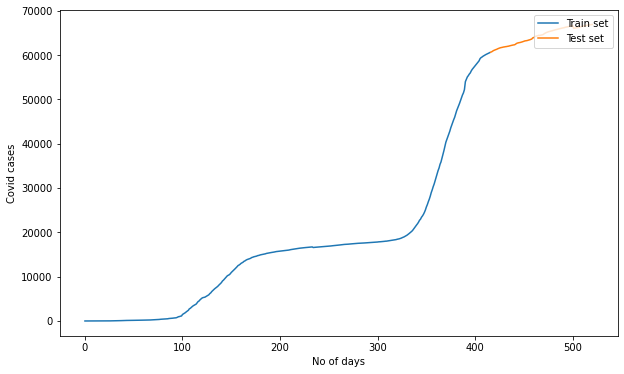

In [ ]:
train_size = int(len(df)*0.8)
train_dataset, test_dataset = df.iloc[:train_size], df.iloc[train_size:]

# Plot train and test data
plt.figure(figsize = (10, 6))
plt.plot(train_dataset.Current)
plt.plot(test_dataset.Current)
plt.xlabel('No of days')
plt.ylabel('Covid cases')
plt.legend(['Train set', 'Test set'], loc='upper right')
#plt.savefig('C:/Users/nious/Documents/Medium/LSTM&GRU/2.jpg', format='jpg', dpi=1000)

print('Dimension of train data: ',train_dataset.shape)
print('Dimension of test data: ', test_dataset.shape)


## Split the Data

In [ ]:
data=df

In [ ]:
# Split train data to X and y
X_train = data.Spatial.values.reshape(-1,1)
y_train = data.Temporal.values.reshape(-1,1)

# Split test data to X and y
X_test =data.Spatial.values.reshape(-1,1)
y_test = data.Temporal.values.reshape(-1,1)

## Data transformation 
A good rule of thumb is that normalized data lead to better performance in Neural Networks. In this project, I use **MinMaxScaler** from sklearn. 

I define different scalers for input and output as they have different shapes. This is especially important for using inverse transform function.

* X_train.shape:  (1192, 3)
* y_train.shape:  (1192, 1)
* X_test.shape:  (299, 3)
* y_test.shape:  (299, 1)

It is important to ensure that the scale of the output variable is in the range 0-1  to match the scale of the activation function (tanh) on the output layer of LSTM, GRU and BiLSTM. Also, input variables are better to be small values, probably in the range of 0-1.

What are the steps?
- Fit the scaler using available training data (It means that the minimum and maximum observable values are estimated using training data.) 

- Apply the scaler to training data 

- Apply the scaler to test data

It is important to note that we should scale the unseen data with the scaler fitted on the training data.

In [ ]:
# Transform X_train, y_train, X_test and y_test

# Different scaler for input and output
scaler_x = MinMaxScaler(feature_range = (0,1))
scaler_y = MinMaxScaler(feature_range = (0,1))

# Fit the scaler using available training data
input_scaler = scaler_x.fit(X_train)
output_scaler = scaler_y.fit(y_train)

# Apply the scaler to training data
train_y_norm = output_scaler.transform(y_train)
train_x_norm = input_scaler.transform(X_train)

# Apply the scaler to test data
test_y_norm = output_scaler.transform(y_test)
test_x_norm = input_scaler.transform(X_test)

## Create a 3D Input Dataset
LSTM, GRU and BiLSTM take a 3D input (num_samples, num_timesteps, num_features). So, I create a helper function, *create_dataset*, to reshape input.

In this project, I define time_steps = 30. It means that the model makes predictions based on the last 30-day data (In the first iteration of the for-loop, the input carries the first 30 days and the output is UWC on the 30th day).

In [ ]:
def create_dataset (X, y, time_steps = 1):
    Xs, ys = [], []
    
    for i in range(len(X)-time_steps):
        v = X[i:i+time_steps, :]
        Xs.append(v)
        ys.append(y[i+time_steps])
        
    return np.array(Xs), np.array(ys)


TIME_STEPS = 30

X_test, y_test = create_dataset(test_x_norm, test_y_norm, TIME_STEPS)
X_train, y_train = create_dataset(train_x_norm, train_y_norm, TIME_STEPS)
print('X_train.shape: ', X_test.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape) 
print('y_test.shape: ', y_train.shape)

X_train.shape:  (491, 30, 1)
y_train.shape:  (491, 1)
X_test.shape:  (491, 30, 1)
y_test.shape:  (491, 1)


# Create BiLSTM, LSTM and GRU model
The first function, create_model_bilstm, creates a BDLSM and gets the number of units (neurons) in hidden layers. The second function, *create_model*, gets two inputs; number of units in hidden layers and model name (LSTM or GRU).

For the sake of simplicity, BiLSTM, LSTM and GRU have 2 hidden layers including 64 neurons and 1 neuron in the output layer.

To make the LSTM and GRU networks robust to changes, the Dropout function is used. Dropout(0.2)  randomly drops 20% of units from the network.

In [ ]:
# Create BiLSTM model
def create_model_bilstm(units):
    model = Sequential()
    # First layer of BiLSTM
    model.add(Bidirectional(LSTM(units = units, return_sequences=True), 
                            input_shape=(X_train.shape[1], X_train.shape[2])))
    # Second layer of BiLSTM
    model.add(Bidirectional(LSTM(units = units)))
    model.add(Dense(1))
    #Compile model
    model.compile(loss='mse', optimizer='adam')
    return model


# Create LSTM or GRU model
def create_model(units, m):
    model = Sequential()
    # First layer of LSTM
    model.add(m (units = units, return_sequences = True, 
                 input_shape = [X_train.shape[1], X_train.shape[2]]))
    model.add(Dropout(0.2)) 
    # Second layer of LSTM
    model.add(m (units = units))                 
    model.add(Dropout(0.2))
    model.add(Dense(units = 1)) 
    #Compile model
    model.compile(loss='mse', optimizer='adam')
    return model


# BiLSTM
model_bilstm = create_model_bilstm(64)

# GRU and LSTM 
model_gru = create_model(64, GRU)
model_lstm = create_model(64, LSTM)

## Fit the models
I train the model with train data for 100 epoch and batch_size = 32. I get the model to use 20% of train data as validation data. It is important to set shuffle = False because the order of the data matters in our project.

To avoid overfitting, I set an early stop to stop training when "val_loss" has not improved after 10 epochs (patience = 10).


In [ ]:
# Fit BiLSTM, LSTM and GRU
def fit_model(model):
    early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                               patience = 10)

    # shuffle = False because the order of the data matters
    history = model.fit(X_train, y_train, epochs = 100, validation_split = 0.2,
                    batch_size = 32, shuffle = False, callbacks = [early_stop])
    return history

history_bilstm = fit_model(model_bilstm)
history_lstm = fit_model(model_lstm)
history_gru = fit_model(model_gru)

Epoch 1/100
13/13 [==============================] - 9s 189ms/step - loss: 0.0082 - val_loss: 0.0026
Epoch 2/100
13/13 [==============================] - 0s 38ms/step - loss: 0.0122 - val_loss: 1.1528e-04
Epoch 3/100
13/13 [==============================] - 0s 38ms/step - loss: 0.0106 - val_loss: 2.2756e-04
Epoch 4/100
13/13 [==============================] - 0s 38ms/step - loss: 0.0390 - val_loss: 0.1257
Epoch 5/100
13/13 [==============================] - 0s 38ms/step - loss: 0.0076 - val_loss: 0.0018
Epoch 6/100
13/13 [==============================] - 0s 39ms/step - loss: 0.0023 - val_loss: 9.9231e-04
Epoch 7/100
13/13 [==============================] - 0s 38ms/step - loss: 0.0051 - val_loss: 6.4060e-05
Epoch 8/100
13/13 [==============================] - 1s 40ms/step - loss: 0.0127 - val_loss: 0.0145
Epoch 9/100
13/13 [==============================] - 0s 39ms/step - loss: 0.0083 - val_loss: 0.0018
Epoch 10/100
13/13 [==============================] - 0s 39ms/step - loss: 0.0100 -

## Inverse target variable for train and test data
After building the model, I have to transform the target variable back to original data space for train and test data using scaler_y.inverse_transform.

In [ ]:
# Note that I have to use scaler_y
y_test = scaler_y.inverse_transform(y_test)
y_train = scaler_y.inverse_transform(y_train)

# Make prediction using BiLSTM, LSTM and GRU
Here I predict UWC using BiLSTM, LSTM and GRU models. Then, I plot true future vs prediction the three models.

In [ ]:
def prediction(model):
    prediction = model.predict(X_test)
    prediction = scaler_y.inverse_transform(prediction)
    return prediction

prediction_bilstm = prediction(model_bilstm)
prediction_lstm = prediction(model_lstm)
prediction_gru = prediction(model_gru)


## Plot true future vs prediction

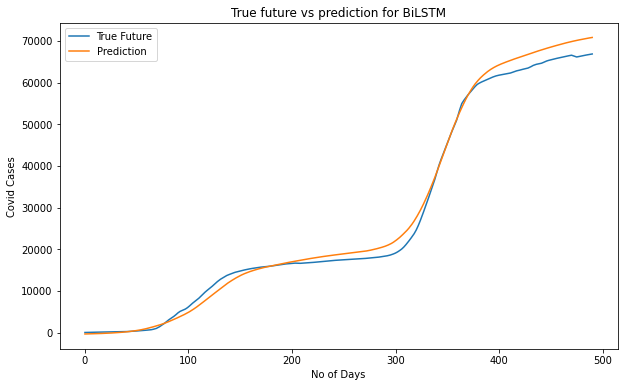

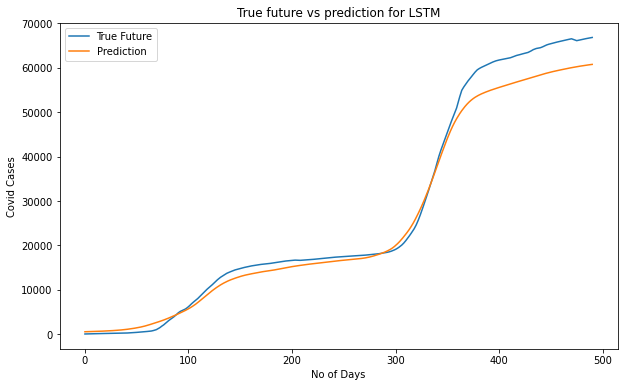

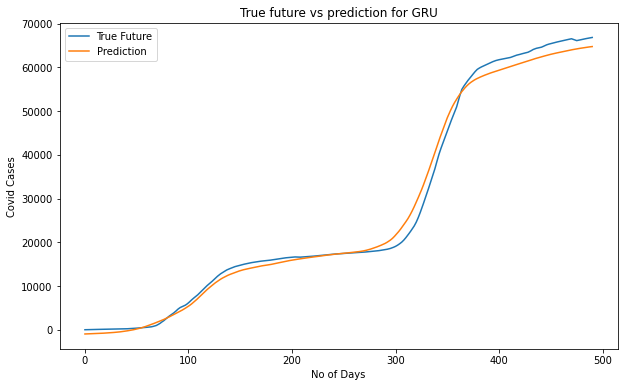

In [ ]:
def plot_future(prediction, model_name, y_test):
    
    plt.figure(figsize=(10, 6))
    
    range_future = len(prediction)

    plt.plot(np.arange(range_future), np.array(y_test), label='True Future')
    plt.plot(np.arange(range_future), np.array(prediction),label='Prediction')

    plt.title('True future vs prediction for ' + model_name)
    plt.legend(loc='upper left')
    plt.xlabel('No of Days')
    plt.ylabel('Covid Cases')
    #plt.savefig('C:/Users/nious/Documents/Medium/LSTM&GRU/predic_'+model_name+'.jpg', format='jpg', dpi=1000)
    
    
plot_future(prediction_bilstm, 'BiLSTM', y_test)
plot_future(prediction_lstm, 'LSTM', y_test)
plot_future(prediction_gru, 'GRU', y_test)

In [ ]:
my_array = np.array(prediction_gru)
df = pd.DataFrame(my_array, columns = ['Name'])
df.to_csv('gru.csv')

In [ ]:
from sklearn.metrics import r2_score

## Calculate RMSE and MAE

In [ ]:
# Define a function to calculate MAE and RMSE
def evaluate_prediction(predictions, actual, model_name):
    errors = predictions - actual
    mse = np.square(errors).mean()/ len(actual)
    rmse = np.sqrt(mse)/ len(actual)
    mae = np.abs(errors).mean()/ len(actual)
    rsq=r2_score(actual, predictions)

    print(model_name + ':')
    print('Mean Absolute Error: {:.4f}'.format(mae))
    print('Root Mean Square Error: {:.4f}'.format(rmse))
    print('R Square Error: {:.4f}'.format(rsq))
    print('')


evaluate_prediction(prediction_bilstm, y_test, 'Bidirectional LSTM')
evaluate_prediction(prediction_lstm, y_test, 'LSTM')
evaluate_prediction(prediction_gru, y_test, 'GRU')


Bidirectional LSTM:
Mean Absolute Error: 3.0569
Root Mean Square Error: 0.1749
R Square Error: 0.9935

LSTM:
Mean Absolute Error: 4.8004
Root Mean Square Error: 0.2979
R Square Error: 0.9811

GRU:
Mean Absolute Error: 2.8725
Root Mean Square Error: 0.1643
R Square Error: 0.9942

